In [2]:
# Imports

import os
import re
import gzip

import pandas as pd
import numpy as np

from IPython.display import display

import matplotlib.pyplot as plt
# dark mode
# plt.rcParams["figure.facecolor"] = "#1e1e1e"
# plt.rcParams["axes.facecolor"] = "#1e1e1e"
plt.style.use("default")

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import umap

from CellPLM.pipeline.cell_type_annotation import CellTypeAnnotationPipeline
from CellPLM.pipeline.cell_embedding import CellEmbeddingPipeline
import anndata as ad

import torch
# if no GPU is available, force torch.load to map everything to CPU
if not torch.cuda.is_available():
    torch_load_old = torch.load
    def torch_load_cpu(*args, **kwargs):
        kwargs['map_location'] = torch.device('cpu')
        return torch_load_old(*args, **kwargs)
    torch.load = torch_load_cpu
    print("Running on CPU mode (CUDA not available).")

/Users/jleto/Library/Python/3.12/lib/python/site-packages/scanpy/_utils/__init__.py:33: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/Users/jleto/Library/Python/3.12/lib/python/site-packages/scanpy/__init__.py:24: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/Users/jleto/Library/Python/3.12/lib/python/site-packages/scanpy/readwrite.py:16: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/Users/jleto/Library/Python/3.12/lib/python/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using t

Running on CPU mode (CUDA not available).


### 1. Gene Expression Data Loading and Merging  

This section loads all spatial transcriptomics files and merges them into one unified gene expression matrix for better downstream analysis.  

The dataset is provided as multiple files, each representing a separate **Visium spatial transcriptomics slide**. Each slide captures **RNA expression patterns** across a thin physical **tissue section**.

These RNA expression patterns show which genes are active and how strongly in different parts of the tissue,  since when a cell uses a gene, it produces mRNA copies of it, *that* is gene expression.

With this technique, RNA molecules released from the tissue bind to barcoded capture spots printed on the slide.  
Each spot records which genes were expressed, basically turning the slide into a grid of thousands of tiny RNA "sensors".  

Because each Visium slide can only capture a limited physical area, the process must be repeated for new sections of tissue, so the dataset comes as multiple files, one for each physical slide (or tissue section).  

Each .txt.gz file contains a **gene expression matrix** for its slide:  
- **Rows** represent genes.  
- **Columns** represent spatial spots (barcoded capture locations on the slide).  
- Each value shows how much RNA from that gene was detected at that spot.  

Each file is loaded into a pandas DataFrame, the spot columns are renamed with the sample’s ID to keep them distinct, then all slides are merged side by side into a single combined matrix.  

In the final merged DataFrame, genes serve as the row labels, and each column corresponds to a spatial spot from one of the slides.

In [3]:
# List Files

data_dir = "GSE253975_data"
print(os.listdir(data_dir))

# show the only txt files
txt_files = [f for f in os.listdir(data_dir) if f.endswith(".gz")]
for file in txt_files:
    print(file)

['GSM8031369_T2465.txt.gz', 'GSM8031368_V11U14-042-C1.json.gz', 'GSM8031367_V11U14-040-A1.json.gz', 'GSM8031363_T2791.txt.gz', 'GSM8031364_V11U14-040-C1.json.gz', 'GSM8031361_V11U14-042-A1.json.gz', 'GSM8031361_T0081.txt.gz', 'GSM8031364_T5498.txt.gz', 'GSM8031362_V11U14-042-D1.json.gz', 'GSM8031368_T3799.txt.gz', 'GSM8031366_V11U14-044-C1.json.gz', 'GSM8031365_V11U14-044-A1.json.gz', 'GSM8031362_T3870.txt.gz', 'GSM8031363_V11U14-042-B1.json.gz', 'GSM8031367_T4424.txt.gz', 'GSM8031366_T5359.txt.gz', 'GSM8031369_V11U14-040-B1.json.gz', 'GSM8031365_T4839.txt.gz']
GSM8031369_T2465.txt.gz
GSM8031368_V11U14-042-C1.json.gz
GSM8031367_V11U14-040-A1.json.gz
GSM8031363_T2791.txt.gz
GSM8031364_V11U14-040-C1.json.gz
GSM8031361_V11U14-042-A1.json.gz
GSM8031361_T0081.txt.gz
GSM8031364_T5498.txt.gz
GSM8031362_V11U14-042-D1.json.gz
GSM8031368_T3799.txt.gz
GSM8031366_V11U14-044-C1.json.gz
GSM8031365_V11U14-044-A1.json.gz
GSM8031362_T3870.txt.gz
GSM8031363_V11U14-042-B1.json.gz
GSM8031367_T4424.txt.gz


In [8]:
# Load All The Text Files

txt_files = [f for f in os.listdir(data_dir) if f.endswith(".txt.gz")]

# load each file and store in a dictionary
dfs = {}
for file in txt_files:
    path = os.path.join(data_dir, file)
    
    # read gene expression matrix: genes as rows, spots as columns
    try:
        df = pd.read_csv(
            path, 
            sep=r"\s+",      # split on any whitespace
            index_col=0      # use the first column (gene names) as row labels
        )

        # give each column a unique name based on its sample
        sample_id = file.split("_")[1].split(".")[0]
        df.columns = [f"{sample_id}_{col}" for col in df.columns]

        # store in dict for later merging
        dfs[file] = df
        # print(f"Loaded {file} with shape {df.shape}")
    except Exception as e:
        # print(f"Failed to load {file}: {e}")
        pass

# merge all samples side-by-side (same genes, different spots)
merged_df = pd.concat(dfs.values(), axis=1)

print("Final merged shape:", merged_df.shape)

# show the raw merged matrix
print("\nRaw Merged Matrix:")
display(merged_df.head())

# show version sorted by total expression (for visualization only)
print("Merged Matrix Sorted by Total Expression:"
    "\n (to highlight the most actively expressed genes across all spots, " 
    "\n allowing visualization of real variation in the data instead of empty zero regions)")
display_df = merged_df.copy()
display_df['total_expression'] = display_df.sum(axis=1)
display_df = display_df.sort_values('total_expression', ascending=False)
display(display_df.drop(columns='total_expression').head(10))

Final merged shape: (36601, 9989)

Raw Merged Matrix:


,T2465_T2465_AAACCGTTCGTCCAGG.1,T2465_T2465_AAACGAGACGGTTGAT.1,T2465_T2465_AAACTGCTGGCTCCAA.1,T2465_T2465_AAAGGCTCTCGCGCCG.1,T2465_T2465_AAAGGGATGTAGCAAG.1,T2465_T2465_AAATACCTATAAGCAT.1,T2465_T2465_AAATCGTGTACCACAA.1,T2465_T2465_AAATGGTCAATGTGCC.1,T2465_T2465_AAATTAACGGGTAGCT.1,T2465_T2465_AAATTTGCGGGTGTGG.1,...,T4839_T4839_TTGCGTCGGCCAACCG.1,T4839_T4839_TTGGAAGAATACAGTC.1,T4839_T4839_TTGGACCATCTGGCAA.1,T4839_T4839_TTGGATATCGTCTACG.1,T4839_T4839_TTGGTCACACTCGTAA.1,T4839_T4839_TTGTAAGGACCTAAGT.1,T4839_T4839_TTGTGAACCTAATCCG.1,T4839_T4839_TTGTGGTAGGAGGGAT.1,T4839_T4839_TTGTGTTTCCCGAAAG.1,T4839_T4839_TTGTTTCCATACAACT.1
MIR1302-2HG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FAM138A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
OR4F5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AL627309.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AL627309.3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Merged Matrix Sorted by Total Expression:
 (to highlight the most actively expressed genes across all spots, 
 allowing visualization of real variation in the data instead of empty zero regions)


,T2465_T2465_AAACCGTTCGTCCAGG.1,T2465_T2465_AAACGAGACGGTTGAT.1,T2465_T2465_AAACTGCTGGCTCCAA.1,T2465_T2465_AAAGGCTCTCGCGCCG.1,T2465_T2465_AAAGGGATGTAGCAAG.1,T2465_T2465_AAATACCTATAAGCAT.1,T2465_T2465_AAATCGTGTACCACAA.1,T2465_T2465_AAATGGTCAATGTGCC.1,T2465_T2465_AAATTAACGGGTAGCT.1,T2465_T2465_AAATTTGCGGGTGTGG.1,...,T4839_T4839_TTGCGTCGGCCAACCG.1,T4839_T4839_TTGGAAGAATACAGTC.1,T4839_T4839_TTGGACCATCTGGCAA.1,T4839_T4839_TTGGATATCGTCTACG.1,T4839_T4839_TTGGTCACACTCGTAA.1,T4839_T4839_TTGTAAGGACCTAAGT.1,T4839_T4839_TTGTGAACCTAATCCG.1,T4839_T4839_TTGTGGTAGGAGGGAT.1,T4839_T4839_TTGTGTTTCCCGAAAG.1,T4839_T4839_TTGTTTCCATACAACT.1
MT-CO1,99,172,517,142,117,95,78,62,93,20,...,31,83,20,31,37,39,18,137,11,9
MT-CO2,59,170,370,170,92,94,52,45,80,13,...,13,76,24,15,27,33,19,93,21,2
MT-CO3,58,116,413,155,104,70,55,57,73,18,...,13,48,19,17,16,31,9,56,15,2
MT-ATP6,44,120,259,123,78,79,56,44,42,7,...,10,41,11,9,16,23,8,37,18,7
MT-ND2,27,92,148,89,59,57,40,26,43,10,...,14,41,23,9,17,30,10,52,10,3
MT-ND1,29,98,180,91,68,59,42,20,39,14,...,17,43,19,18,11,13,16,80,17,7
MT-ND4,46,100,288,90,64,73,38,41,57,8,...,10,26,14,19,23,21,10,40,9,4
MT-ND3,27,79,199,82,57,44,46,30,40,10,...,6,12,10,20,18,23,8,34,9,8
MT-CYB,40,99,203,91,64,61,43,30,39,12,...,15,26,14,9,15,22,12,46,3,5
HSP90AA1,1,25,139,41,14,17,8,18,14,1,...,3,8,4,1,6,10,3,19,5,0


### 2. Data Normalization  

This step normalizes raw gene expression counts across spatial spots to make values comparable between slides.

Each slide can be thought of as its own *small experiment*, which means it can introduce **batch effects**, 
non-biological differences caused by variations in sample preparation, imaging, or sequencing depth (how much RNA was captured).  

Normalization corrects for these differences by applying methods such as scaling factors and log-transform compression. 

It ensures that expression values represent actual biological variation rather than technical noise, preparing the matrix for downstream dimensionality reduction and model-based embedding.

In [9]:
# Normalize the merged gene expression matrix

# 1. compute total counts per spot (column sum) to use as a scaling factor 
library_sizes = merged_df.sum(axis=0)

# 2. for each column (spot), divide its values by the total counts for that spot
#    so expression levels are scaled relative to how much RNA was captured in that spot,
normalized_df = merged_df.div(library_sizes, axis=1) * 1e4  # scale to 10,000

# 3. log-transform to compress large differences
normalized_df = np.log1p(normalized_df) # take the natural logarithm of (x + 1) 

# 4. remove genes that are all zero across all spots
normalized_df = normalized_df.loc[normalized_df.sum(axis=1) > 0]

print("Normalized shape:", normalized_df.shape)

# show the raw normalized matrix
print("\nNormalized Matrix")
display(normalized_df.head())

# show version sorted by total expression for normalized data (for visualization only)
print("Normalized Matrix Sorted by Total Expression:"
    "\n (to highlight the most actively expressed genes across all spots, " 
    "\n allowing visualization of real variation in the data instead of empty zero regions)")
display_norm = normalized_df.copy()
display_norm['total_expression'] = display_norm.sum(axis=1)
display_norm = display_norm.sort_values('total_expression', ascending=False)
display(display_norm.drop(columns='total_expression').head(10))

Normalized shape: (24377, 9989)

Normalized Matrix


,T2465_T2465_AAACCGTTCGTCCAGG.1,T2465_T2465_AAACGAGACGGTTGAT.1,T2465_T2465_AAACTGCTGGCTCCAA.1,T2465_T2465_AAAGGCTCTCGCGCCG.1,T2465_T2465_AAAGGGATGTAGCAAG.1,T2465_T2465_AAATACCTATAAGCAT.1,T2465_T2465_AAATCGTGTACCACAA.1,T2465_T2465_AAATGGTCAATGTGCC.1,T2465_T2465_AAATTAACGGGTAGCT.1,T2465_T2465_AAATTTGCGGGTGTGG.1,...,T4839_T4839_TTGCGTCGGCCAACCG.1,T4839_T4839_TTGGAAGAATACAGTC.1,T4839_T4839_TTGGACCATCTGGCAA.1,T4839_T4839_TTGGATATCGTCTACG.1,T4839_T4839_TTGGTCACACTCGTAA.1,T4839_T4839_TTGTAAGGACCTAAGT.1,T4839_T4839_TTGTGAACCTAATCCG.1,T4839_T4839_TTGTGGTAGGAGGGAT.1,T4839_T4839_TTGTGTTTCCCGAAAG.1,T4839_T4839_TTGTTTCCATACAACT.1
AL627309.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AL627309.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LINC01409,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FAM87B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LINC01128,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Normalized Matrix Sorted by Total Expression:
 (to highlight the most actively expressed genes across all spots, 
 allowing visualization of real variation in the data instead of empty zero regions)


,T2465_T2465_AAACCGTTCGTCCAGG.1,T2465_T2465_AAACGAGACGGTTGAT.1,T2465_T2465_AAACTGCTGGCTCCAA.1,T2465_T2465_AAAGGCTCTCGCGCCG.1,T2465_T2465_AAAGGGATGTAGCAAG.1,T2465_T2465_AAATACCTATAAGCAT.1,T2465_T2465_AAATCGTGTACCACAA.1,T2465_T2465_AAATGGTCAATGTGCC.1,T2465_T2465_AAATTAACGGGTAGCT.1,T2465_T2465_AAATTTGCGGGTGTGG.1,...,T4839_T4839_TTGCGTCGGCCAACCG.1,T4839_T4839_TTGGAAGAATACAGTC.1,T4839_T4839_TTGGACCATCTGGCAA.1,T4839_T4839_TTGGATATCGTCTACG.1,T4839_T4839_TTGGTCACACTCGTAA.1,T4839_T4839_TTGTAAGGACCTAAGT.1,T4839_T4839_TTGTGAACCTAATCCG.1,T4839_T4839_TTGTGGTAGGAGGGAT.1,T4839_T4839_TTGTGTTTCCCGAAAG.1,T4839_T4839_TTGTTTCCATACAACT.1
MT-CO1,6.977681,6.274542,6.382467,5.935047,6.298345,5.945996,6.052970,5.711783,6.089345,6.706039,...,6.137721,5.918982,5.608516,5.907713,5.669318,5.206177,5.533788,6.156192,5.215089,5.579464
MT-CO2,6.460731,6.262868,6.048599,6.114583,6.058460,5.935442,5.648679,5.392560,5.939141,6.275914,...,5.271669,5.831122,5.790226,5.184671,5.355514,5.040119,5.587647,5.769813,5.859126,4.088511
MT-ND2,5.680882,5.650472,5.135843,5.469431,5.615515,5.436913,5.387371,4.847313,5.320578,6.014114,...,5.345410,5.216463,5.747799,4.677573,4.895664,4.945456,4.949157,5.190915,5.120323,4.488373
MT-CO3,6.443663,5.881546,6.158297,6.022424,6.180792,5.641548,5.704577,5.627990,5.847826,6.600814,...,5.271669,5.373300,5.557415,5.309175,4.835507,4.978016,4.844584,5.264625,5.523794,4.088511
MT-ND1,5.752105,5.713436,5.330542,5.491561,5.757004,5.471252,5.435943,4.587301,5.223441,6.349888,...,5.538724,5.263838,5.557415,5.366059,4.464418,4.118470,5.416499,5.619747,5.648488,5.329228
MT-ATP6,6.167916,5.915355,5.692935,5.791813,5.893800,5.762097,5.722536,5.370190,5.297164,5.658486,...,5.010844,5.216463,5.013674,4.677573,4.835507,4.681916,4.727784,4.852843,5.705451,5.329228
MT-ND4,6.212276,5.733573,5.798728,5.480557,5.696577,5.683367,5.336318,5.299913,5.601228,5.791582,...,5.010844,4.764113,5.253411,5.419880,5.195992,4.591826,4.949157,4.930219,5.015626,4.773241
MT-ND3,5.680882,5.498710,5.430427,5.387873,5.581157,5.179337,5.526536,4.989367,5.248624,6.014114,...,4.504452,4.000826,4.919028,5.470952,4.952407,4.681916,4.727784,4.768974,5.015626,5.462153
MT-CYB,6.072815,5.723555,5.450242,5.491561,5.696577,5.504450,5.459372,4.989367,5.223441,6.196028,...,5.414085,4.764113,5.253411,4.677573,4.771498,4.637885,5.130296,5.069038,3.930193,4.994693
MBP,4.589067,4.033406,2.762871,3.316125,4.037044,4.491806,3.515840,3.556209,4.135549,5.323408,...,4.324340,3.915477,4.013637,4.428913,4.771498,3.513279,4.844584,4.084280,5.015626,5.779448


#### 3. Principal Component Analysis (PCA)  

PCA is a classical method used to reduce thousands of gene expression values into a smaller set of features, typically around 50 principal components per spatial spot. Each principal component captures one of the strongest overall patterns in how genes vary across the tissue.

It works by finding the main directions (or axes) of variation in the data, summarizing the most important patterns while filtering out noise.  

This step makes the data much easier to interpret and visualize, allowing us to later apply clustering or dimensionality reduction techniques like UMAP to reveal meaningful biological relationships between spots.

In [7]:
# Run PCA

from sklearn.decomposition import PCA

# initialize PCA to keep 50 components
pca = PCA(n_components=50)

# PCA expects transposed data: rows = samples (spots) and columns = features (genes)
pca_result = pca.fit_transform(normalized_df.T)

# store the result in a new DataFrame
pca_df = pd.DataFrame(pca_result, 
                      index=normalized_df.columns, 
                      columns=[f'PC{i+1}' for i in range(50)])

print("PCA result shape:", pca_df.shape)
display(pca_df.head())

PCA result shape: (6865, 50)


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50
T4515_T4515_AAACAGAGCGACTCCT.1,-6.533364,5.047889,-2.015911,0.934689,1.272930,1.566889,-1.703047,3.858636,-1.949785,1.815216,...,-1.662442,-0.532130,0.377217,0.376101,-1.217418,-0.837071,-0.751332,-1.006714,1.531466,-0.065612
T4515_T4515_AAACAGCTTTCAGAAG.1,-4.819116,4.963324,-0.281732,4.138125,1.332639,1.915522,-0.789142,-2.557176,-1.221392,3.493186,...,0.239443,0.025771,0.953426,-1.713715,-2.081789,3.291765,0.108573,-2.070533,-2.158070,-0.197065
T4515_T4515_AAACCGGGTAGGTACC.1,-17.603321,-1.895146,1.721076,-2.113905,-1.568327,-1.965707,-0.980726,1.857438,2.639845,-0.064254,...,0.730854,0.677263,-0.927437,-0.452119,-0.447117,0.350059,2.977105,0.814368,2.292722,-2.297928
T4515_T4515_AAACCTCATGAAGTTG.1,-12.780376,2.128913,6.299701,1.787659,-0.150427,0.393606,-3.172686,1.660672,0.006273,-2.130340,...,-2.264357,2.173341,0.568887,-0.313746,0.505085,-3.851641,2.923732,-2.216912,-0.052503,-0.167467
T4515_T4515_AAACGAGACGGTTGAT.1,3.478729,6.622718,-5.529121,2.309435,1.324815,-1.124218,-1.026777,-0.245369,0.619452,-1.527921,...,0.349899,-0.173524,0.333895,-2.029776,0.680328,1.496271,0.292451,0.206495,-1.777881,0.655502


/Users/jleto/Library/Python/3.12/lib/python/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


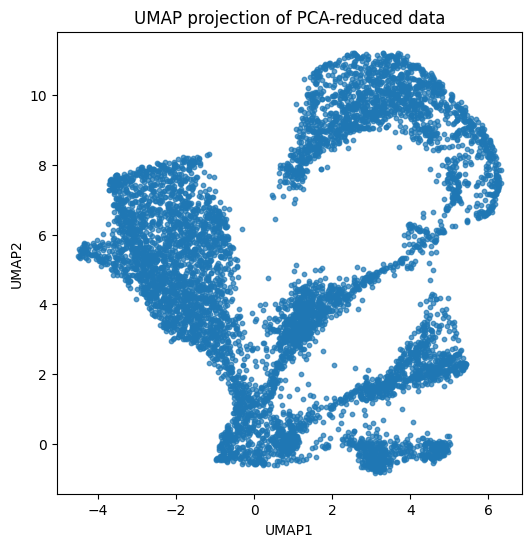

In [8]:
# Visualize With UMAP

import umap

# initialize UMAP: reduce PCA components to 2 dimensions
umap_model = umap.UMAP(
    n_components=2, # reduce to 2 dimensions
    n_neighbors=15, # how many neighbors UMAP uses to learn local structure
    min_dist=0.2,   # controls cluser spacing
    random_state=1  # dont use a random seed
)

# fit and transform PCA data
umap_result = umap_model.fit_transform(pca_df)

# put results into a DataFrame for plotting
umap_df = pd.DataFrame(umap_result, index=pca_df.index, columns=['UMAP1', 'UMAP2'])

plt.figure(figsize=(6,6))
plt.scatter(umap_df['UMAP1'], umap_df['UMAP2'], s=10, alpha=0.7)
plt.title("UMAP projection of PCA-reduced data")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.show()

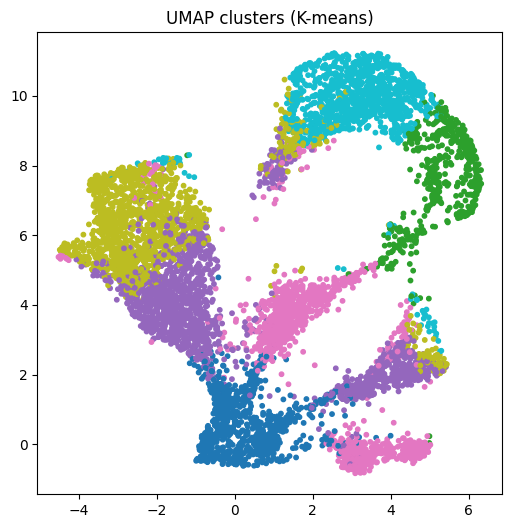

In [9]:
# Cluster With KMeans

from sklearn.cluster import KMeans

kmeans = KMeans(
    n_clusters=6,   # how many clusters to find
    random_state=1  # set the random seed
    )
cluster_labels = kmeans.fit_predict(pca_df) # list of which cluster each spot belongs to

umap_df['cluster'] = cluster_labels # add cluster labels as a column, every row (spot) has its cluster assignment

plt.figure(figsize=(6,6))
plt.scatter(umap_df['UMAP1'], umap_df['UMAP2'], c=umap_df['cluster'], cmap='tab10', s=10) # catterplot of UMAP dimensions, colored by cluster label
plt.title("UMAP clusters (K-means)")
plt.show()

#### Clustering Results and Next Steps

The above scatter plot shows groups of spatial spots with similar transcriptional features, where each dot represents a single spot on the tissue.
Spots are clustered together based on how similar their gene-expression profiles are across thousands of genes.

The next phase will focus on making this data biologically meaningful.
That involves mapping the clusters back to their spatial positions on the original tissue (using the .json metadata) and identifying marker genes, genes that are highly expressed within each cluster.
This can help reveal which parts of the tissue have stronger expression from certain cell types or biological processes.

In the context of the Parkinson’s dataset, this is especially relevant since the original study suggested that localized immune-related gene expression within the tissue may play a key role in the degeneration of neurons.



### 4. CellPLM

CellPLM is a transformer-based model trained on large-scale single-cell and spatial transcriptomics data to learn generalizable biological representations.
Instead of manually computing features through methods like PCA, CellPLM encodes each gene-expression profile into a dense vector, or embedding, that captures higher-level biological relationships between genes and cell states.

Each spot in the dataset is transformed into one of these embeddings, allowing spots with similar transcriptional patterns to appear close together in the embedding space, even if the relationships are complex or nonlinear.

In [10]:
# Run CellPLM
3
from CellPLM.pipeline.cell_type_annotation import CellTypeAnnotationPipeline
from CellPLM.pipeline.cell_embedding import CellEmbeddingPipeline
import anndata as ad

# convert the normalized dataframe to AnnData
adata = ad.AnnData(normalized_df.T)

# initialize the pretrained model
pipeline = CellEmbeddingPipeline(
    pretrain_prefix="20230926_85M",
    pretrain_directory="ckpt/"
)
embeddings = pipeline.predict(adata) # get embeddings


Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


Automatically converting gene symbols to ensembl ids...


479 input query terms found dup hits:	[('LINC00115', 2), ('LINC01786', 2), ('SLC35E2A', 2), ('TNFRSF14-AS1', 3), ('LINC01346', 2), ('LINC0
5429 input query terms found no hit:	['AL627309.1', 'AL627309.5', 'AL645608.2', 'AL645608.7', 'AL391244.2', 'TMEM88B', 'AL645728.1', 'AL6
/Users/jleto/Library/Python/3.12/lib/python/site-packages/CellPLM/utils/data.py:81: UserWarning: Batch labels not found in AnnData.obs. All cells are considered from the same sample by default.
  warnings.warn(


After filtering, 14861 genes remain.


/Users/jleto/Library/Python/3.12/lib/python/site-packages/CellPLM/utils/data.py:20: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:55.)
  return torch.sparse_csr_tensor(x.indptr, x.indices, x.data, (x.shape[0], x.shape[1])).to_sparse().float().coalesce()


In [11]:
# Show Embeddings

print(embeddings.shape)
print(embeddings[:5])

torch.Size([6865, 512])
tensor([[ 0.1805, -0.0142,  0.0432,  ..., -0.8834, -0.1158, -0.0424],
        [ 0.1942, -0.0020,  0.0383,  ..., -0.8888, -0.1228, -0.0498],
        [ 0.1850, -0.0058,  0.0427,  ..., -0.8809, -0.1258, -0.0362],
        [ 0.1759, -0.0099,  0.0315,  ..., -0.8706, -0.1033, -0.0430],
        [ 0.1824, -0.0175,  0.0489,  ..., -0.8824, -0.1075, -0.0459]])


/Users/jleto/Library/Python/3.12/lib/python/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


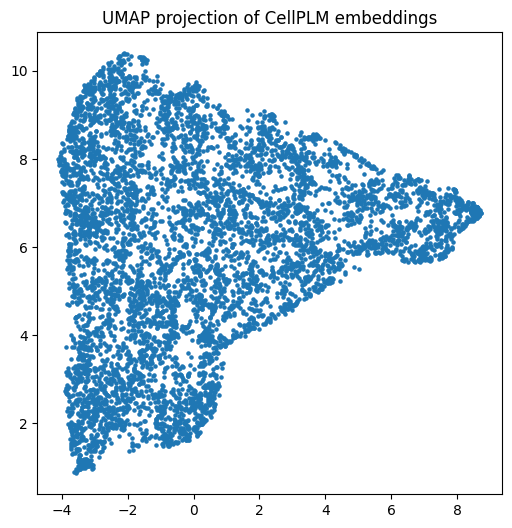

In [12]:
# Visualize With UMAP

import umap
reducer = umap.UMAP(random_state=1) # create the umap object
umap_emb = reducer.fit_transform(embeddings.detach().cpu().numpy()) # run umap

# plot it
plt.figure(figsize=(6,6))
plt.scatter(umap_emb[:,0], umap_emb[:,1], s=5)
plt.title("UMAP projection of CellPLM embeddings")
plt.show()

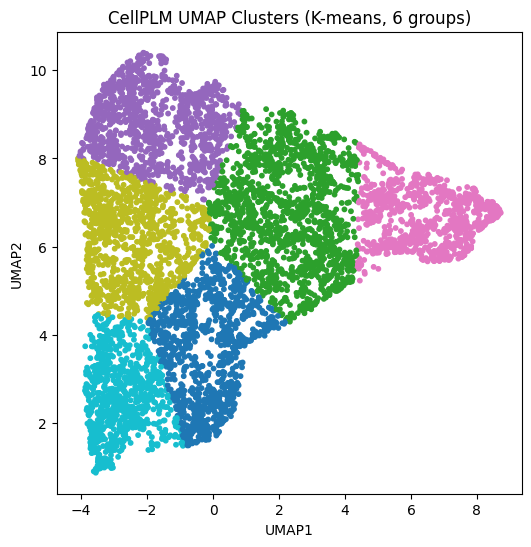

In [13]:
# Cluster With KMeans

from sklearn.cluster import KMeans
labels = KMeans(n_clusters=6, random_state=1).fit_predict(umap_emb) # run kmeans

import matplotlib.pyplot as plt

# plot it
plt.figure(figsize=(6,6))
plt.scatter(
    umap_emb[:, 0],
    umap_emb[:, 1],
    c=labels,
    cmap='tab10',
    s=10
)
plt.title("CellPLM UMAP Clusters (K-means, 6 groups)")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.show()

#### Clustering Results and Next Steps

The scatter plot above shows groups of spatial spots with similar transcriptional and contextual features, where each dot represents a single spot from the tissue.
Unlike PCA, which clusters spots by raw gene-expression similarity, CellPLM embeddings incorporate both gene–gene and cell–cell relationships learned from large-scale biological data.

Visually, the clusters here appear more clearly defined compared to those from PCA.
However, further analysis is needed to determine whether these divisions are biologically meaningful, as the model is designed to capture functional and spatial context rather than just expression magnitude.

The next phase will focus on making this data biologically meaningful.
That involves mapping the clusters back to their spatial positions on the original tissue (using the .json metadata) and identifying marker genes, genes that are highly expressed within each cluster.
This can help reveal which parts of the tissue have stronger expression from certain cell types or biological processes.

In the context of the Parkinson’s dataset, this is especially relevant since the original study suggested that localized immune-related gene expression within the tissue may play a key role in the degeneration of neurons.

### 5. Load JSON Files

In [5]:
# Load JSON Files — Spatial Coordinates and Metadata Per Spot

import gzip, json, pandas as pd
from pathlib import Path

data_dir = "GSE253975_data"
print(os.listdir(data_dir))

json_dir = Path(data_dir)
json_files = sorted(json_dir.glob("*.json.gz"))

coords_list = []

for file_path in json_files:
    sample_id = file_path.stem.split("_")[0]  # e.g. GSM8031360
    with gzip.open(file_path, "rt") as f:
        data = json.load(f)
        oligos = pd.DataFrame(data["oligo"])
        oligos["sample_id"] = sample_id
        coords_list.append(oligos)

coords_df = pd.concat(coords_list, ignore_index=True)
coords_df = coords_df.rename(columns={"imageX": "x_coord", "imageY": "y_coord"})

coords_df.head()

['GSM8031369_T2465.txt.gz', 'GSM8031368_V11U14-042-C1.json.gz', 'GSM8031367_V11U14-040-A1.json.gz', 'GSM8031363_T2791.txt.gz', 'GSM8031364_V11U14-040-C1.json.gz', 'GSM8031361_V11U14-042-A1.json.gz', 'GSM8031361_T0081.txt.gz', 'GSM8031364_T5498.txt.gz', 'GSM8031362_V11U14-042-D1.json.gz', 'GSM8031368_T3799.txt.gz', 'GSM8031366_V11U14-044-C1.json.gz', 'GSM8031365_V11U14-044-A1.json.gz', 'GSM8031362_T3870.txt.gz', 'GSM8031363_V11U14-042-B1.json.gz', 'combined_metadata.json', 'GSM8031367_T4424.txt.gz', 'GSM8031366_T5359.txt.gz', 'GSM8031369_V11U14-040-B1.json.gz', 'GSM8031365_T4839.txt.gz']


,x,y,row,col,dia,x_coord,y_coord,tissue,sample_id
0,4825,30073,0,0,53.25297,5938.0490,5803.2710,NaN,GSM8031361
1,4875,30160,1,1,53.25297,5866.8457,5762.1787,NaN,GSM8031361
2,4925,30073,0,2,53.25297,5938.1963,5721.3433,NaN,GSM8031361
3,4975,30160,1,3,53.25297,5866.9937,5680.2510,NaN,GSM8031361
4,5025,30073,0,4,53.25297,5938.3440,5639.4160,NaN,GSM8031361


In [7]:
# Keep only rows where 'tissue' is True
coords_tissue = coords_df[coords_df["tissue"] == True].copy()

print(coords_tissue.shape)
coords_tissue.head()

(9989, 9)


,x,y,row,col,dia,x_coord,y_coord,tissue,sample_id
1303,5975,31900,21,23,53.25297,4442.9326,4858.4043,True,GSM8031361
1304,6025,31813,20,24,53.25297,4514.2837,4817.5690,True,GSM8031361
1305,6075,31900,21,25,53.25297,4443.0806,4776.4766,True,GSM8031361
1306,6125,31813,20,26,53.25297,4514.4310,4735.6416,True,GSM8031361
1307,6175,31900,21,27,53.25297,4443.2285,4694.5493,True,GSM8031361
